In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import corner
from jacket.modelling import hmc

\begin{align}
y_i &\sim \mathcal{N}(\beta_0 + \beta_1 x_i, \sigma) \\
\beta_0 &\sim \mathcal{N}(0, 1) \\
\beta_1 &\sim \mathcal{N}(0, 1) \\
\sigma &\sim Exp(1)
\end{align}

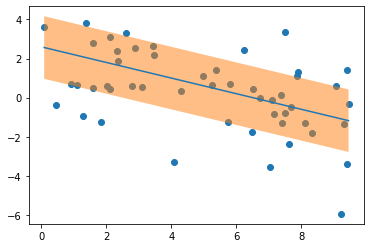

In [3]:
beta0 = 2.6
beta1 = -0.4
sigma = 1.6
n = 50

x = jnp.array(np.sort(np.random.uniform(0., 10., size=n)))
ymean = beta0 + beta1 * x
y = jnp.array(np.random.normal(ymean, sigma))

plt.scatter(x, y)
plt.plot(x, ymean)
plt.fill_between(x, ymean - sigma, ymean + sigma, alpha=0.5)

In [4]:
def ln_posterior(params, data):
    target = 0
    target += stats.norm.logpdf(params['beta0'], 1., 3.)
    target += stats.norm.logpdf(params['beta1'], 0., 1.)
    target += stats.expon.logpdf(jnp.exp(params['sigma']))
    ymean = params['beta0'] + params['beta1'] * data['x']
    target += stats.norm.logpdf(data['y'], ymean, jnp.exp(params['sigma'])).sum()
    return target.sum()

In [5]:
params = dict(
    beta0=jnp.zeros(1),
    beta1=jnp.zeros(1),
    sigma=jnp.zeros(1),
)

data = dict(
    x=x,
    y=y,
)

@jax.jit
def ln_unnormalized_posterior(params):
    return ln_posterior(params, data)


In [6]:
samples, momentum = hmc.sample(ln_unnormalized_posterior, params, n_chains=10, n_samples=1000, n_warmup=2000, leapfrog_steps=15, step_size=1.5e-2)

100%|█████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 710.48it/s]


In [12]:
flatten = lambda t: jax.tree_util.tree_map(lambda x: x.reshape(x.shape[0], -1), t)

In [13]:
samples = flatten(samples)
momentum = flatten(momentum)

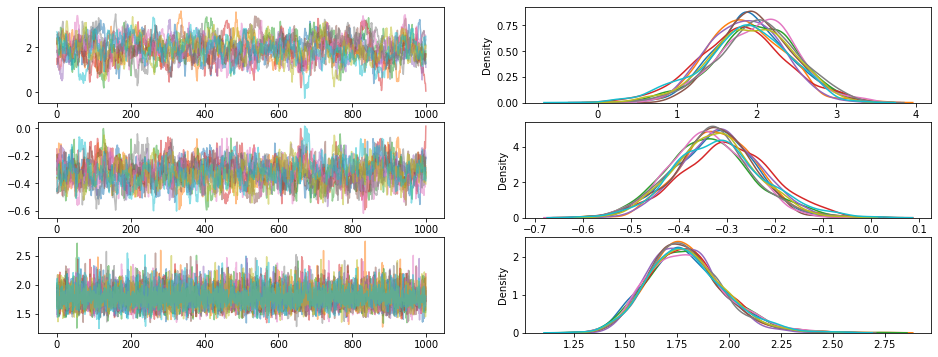

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))
for i in range(10):
    ax[0,0].plot(samples['beta0'][i], alpha=0.5)
    ax[1,0].plot(samples['beta1'][i], alpha=0.5)
    ax[2,0].plot(jnp.exp(samples['sigma'][i]), alpha=0.5)
    sns.kdeplot(samples['beta0'][i], ax=ax[0,1])
    sns.kdeplot(samples['beta1'][i], ax=ax[1,1])
    sns.kdeplot(jnp.exp(samples['sigma'][i]), ax=ax[2,1])

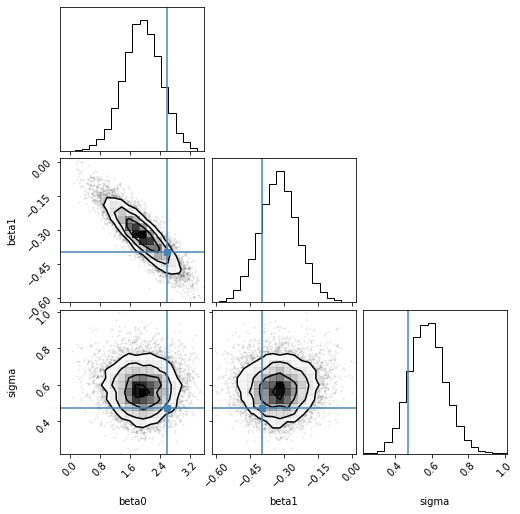

In [15]:
corner.corner(samples, truths=(beta0, beta1, jnp.log(sigma)));

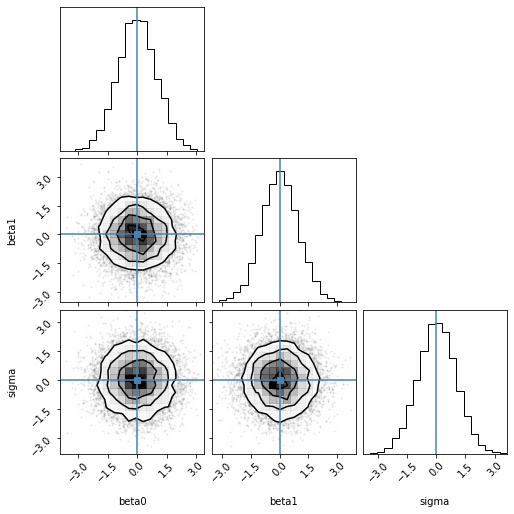

In [16]:
corner.corner(momentum, truths=np.zeros(3));